# Boosting to Uniformity

In physics applications frequently we need to achieve uniformity of predictions along some features.
For instance, when testing for the existence of a new particle, we need a classifier to be uniform in background along the mass (otherwise one can get false discovery due to so-called peaking background).

This notebook contains some comparison of classifiers. The target is to obtain flat effiency in __signal__ (without significally loosing quality of classification) in Dalitz features.

The classifiers compared are 

* plain __GradientBoosting__ 
* __uBoost__
* gradient boosting with knn-Ada loss (__UGB+knnAda__) 
* gradient boosting with FlatnessLoss (__UGB+FlatnessLoss__)

We use dataset from paper about `uBoost` for demonstration purposes.
We have a plenty of data here, so results are quite stable

In [1]:
# downloading data
!wget -O ../data/dalitzdata.root -nc https://github.com/arogozhnikov/hep_ml/blob/data/data_to_download/dalitzdata.root?raw=true

File ‘../data/dalitzdata.root’ already there; not retrieving.


In [2]:
import numpy as np
from matplotlib import pyplot as plt

# we'll create our own wrapper for sklearn classifiers instead of using rep
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from hep_ml import gradientboosting as ugb
from hep_ml import uboost
from hep_ml.commonutils import train_test_split

### Loading data

In [3]:
import uproot

used_columns = ["Y1", "Y2", "Y3", "M2AB", "M2AC"]
# Use uproot instead of root_numpy
with uproot.open("../data/dalitzdata.root") as file:
    tree = file["tree"]
    # Read all branches and convert to pandas DataFrame
    data = tree.arrays(library="pd")

labels = data["labels"]
data = data.drop("labels", axis=1)

## Distributions in the Dalitz features for signal and background
As we can see, the background is distributed mostly in the corners of Dalitz plot, <br />
and for traditional classifiers this results in poor effieciency of signal in the corners.

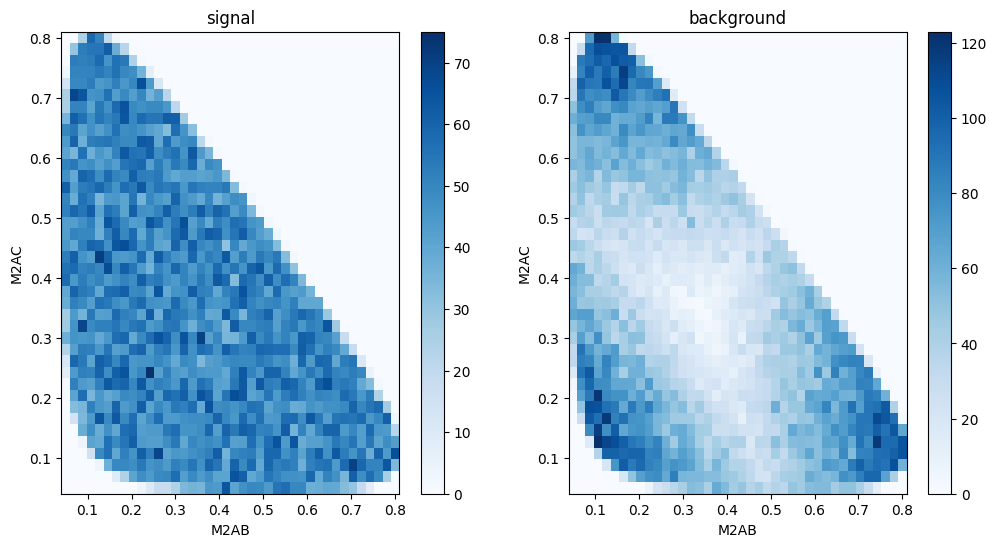

In [4]:
def plot_distribution(data_frame, var_name1="M2AB", var_name2="M2AC", bins=40):
    """The function to plot 2D distribution histograms"""
    plt.hist2d(data_frame[var_name1], data_frame[var_name2], bins=40, cmap=plt.cm.Blues)
    plt.xlabel(var_name1)
    plt.ylabel(var_name2)
    plt.colorbar()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.title("signal"), plot_distribution(data[labels == 1])
plt.subplot(1, 2, 2), plt.title("background"), plot_distribution(data[labels == 0])
pass

## Preparation of train/test datasets

In [5]:
trainX, testX, trainY, testY = train_test_split(data, labels, random_state=42)

## Setting up classifiers, training

In [6]:
uniform_features = ["M2AB", "M2AC"]
train_features = ["Y1", "Y2", "Y3"]
n_estimators = 150
base_estimator = DecisionTreeClassifier(max_depth=4)

__uBoost__ training takes much time, so we reduce number of efficiency_steps, use prediction smoothing and run uBoost in threads

In [7]:
# Custom implementation to replace rep functionality
class SklearnClassifier:
    """Simple wrapper for sklearn classifiers to mimic rep.estimators.SklearnClassifier"""

    def __init__(self, base_estimator, features=None):
        self.base_estimator = base_estimator
        self.features = features

    def fit(self, X, y):
        if self.features is not None:
            X = X[self.features]
        self.base_estimator.fit(X, y)
        return self

    def predict_proba(self, X):
        if self.features is not None:
            X = X[self.features]
        return self.base_estimator.predict_proba(X)

    def predict(self, X):
        if self.features is not None:
            X = X[self.features]
        return self.base_estimator.predict(X)


class ClassifiersFactory:
    """Simple implementation to replace rep.metaml.ClassifiersFactory"""

    def __init__(self):
        self.classifiers = {}

    def __setitem__(self, key, classifier):
        self.classifiers[key] = classifier

    def fit(self, X, y, parallel_profile=None):
        # Simple sequential fitting, ignoring parallel_profile for now
        for name, clf in self.classifiers.items():
            print(f"Training {name}...")
            clf.fit(X, y)

    def test_on(self, X, y):
        return Report(self.classifiers, X, y)


class Report:
    """Simple report class to replace REP functionality"""

    def __init__(self, classifiers, X, y):
        self.classifiers = classifiers
        self.X = X
        self.y = y
        self.predictions = {}
        for name, clf in classifiers.items():
            self.predictions[name] = clf.predict_proba(X)[:, 1]

    def learning_curve(self, metric, steps=1):
        """Plot learning curves for all classifiers"""
        from sklearn.metrics import roc_auc_score

        plt.figure(figsize=(10, 6))

        for name, clf in self.classifiers.items():
            if hasattr(clf.base_estimator, "staged_predict_proba"):
                scores = []
                n_estimators = []
                for i, pred_proba in enumerate(
                    clf.base_estimator.staged_predict_proba(self.X if clf.features is None else self.X[clf.features])
                ):
                    if i % steps == 0:
                        score = roc_auc_score(self.y, pred_proba[:, 1])
                        scores.append(score)
                        n_estimators.append(i + 1)
                plt.plot(n_estimators, scores, label=name)

        plt.xlabel("n_estimators")
        plt.ylabel("ROC AUC")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def roc(self):
        """Generate ROC curves"""
        from sklearn.metrics import auc, roc_curve

        class ROCPlotter:
            def __init__(self, classifiers, predictions, y_true):
                self.classifiers = classifiers
                self.predictions = predictions
                self.y_true = y_true

            def plot(self, new_plot=True, figsize=None):
                if new_plot:
                    plt.figure(figsize=figsize or [10, 9])

                for name, y_score in self.predictions.items():
                    fpr, tpr, _ = roc_curve(self.y_true, y_score)
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

                plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title("ROC Curves")
                plt.legend(loc="lower right")
                plt.grid(True, alpha=0.3)
                plt.show()

        return ROCPlotter(self.classifiers, self.predictions, self.y)

    def efficiencies_2d(self, features, efficiency=0.5, signal_label=1, n_bins=15, labels_dict=None):
        """Plot 2D efficiency maps"""

        # Get signal mask
        signal_mask = self.y == signal_label

        n_classifiers = len(self.classifiers)
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        for idx, (name, y_score) in enumerate(self.predictions.items()):
            if idx >= 4:
                break

            ax = axes[idx]

            # Find threshold for desired efficiency
            signal_scores = y_score[signal_mask]
            threshold = np.percentile(signal_scores, (1 - efficiency) * 100)

            # Create 2D histogram
            x_data = self.X[features[0]][signal_mask]
            y_data = self.X[features[1]][signal_mask]
            scores = y_score[signal_mask]

            # Calculate efficiency in each bin
            x_bins = np.linspace(x_data.min(), x_data.max(), n_bins + 1)
            y_bins = np.linspace(y_data.min(), y_data.max(), n_bins + 1)

            efficiency_map = np.zeros((n_bins, n_bins))

            for i in range(n_bins):
                for j in range(n_bins):
                    mask = (
                        (x_data >= x_bins[i])
                        & (x_data < x_bins[i + 1])
                        & (y_data >= y_bins[j])
                        & (y_data < y_bins[j + 1])
                    )
                    if mask.sum() > 0:
                        efficiency_map[j, i] = (scores[mask] >= threshold).mean()

            im = ax.imshow(
                efficiency_map,
                extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                aspect="auto",
                origin="lower",
                cmap="RdBu_r",
                vmin=0,
                vmax=1,
            )
            ax.set_xlabel(features[0])
            ax.set_ylabel(features[1])
            ax.set_title(f"{name} (target efficiency = {efficiency})")
            plt.colorbar(im, ax=ax)

        plt.tight_layout()
        plt.show()


# Create classifiers
classifiers = ClassifiersFactory()

base_ada = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)
classifiers["AdaBoost"] = SklearnClassifier(base_ada, features=train_features)

knnloss = ugb.KnnAdaLossFunction(uniform_features, knn=10, uniform_label=1)
ugbKnn = ugb.UGradientBoostingClassifier(
    loss=knnloss, max_depth=4, n_estimators=n_estimators, learning_rate=0.4, train_features=train_features
)
classifiers["uGB+knnAda"] = SklearnClassifier(ugbKnn)

uboost_clf = uboost.uBoostClassifier(
    uniform_features=uniform_features,
    uniform_label=1,
    base_estimator=base_estimator,
    n_estimators=n_estimators,
    train_features=train_features,
    efficiency_steps=12,
    n_threads=4,
)
classifiers["uBoost"] = SklearnClassifier(uboost_clf)

flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3.0, power=1.3, uniform_label=1)
ugbFL = ugb.UGradientBoostingClassifier(
    loss=flatnessloss, max_depth=4, n_estimators=n_estimators, learning_rate=0.1, train_features=train_features
)
classifiers["uGB+FL"] = SklearnClassifier(ugbFL)

classifiers.fit(trainX, trainY, parallel_profile="threads-4")
pass

Training AdaBoost...
Training uGB+knnAda...


/data/software/miniforge3/envs/hepml310/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


Training uBoost...


/data/software/miniforge3/envs/hepml310/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
/data/software/miniforge3/envs/hepml310/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


Training uGB+FL...


/data/software/miniforge3/envs/hepml310/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


## Let's look at the results of training

dependence of classification quality on the number of trees built (ROC AUC - an area under the ROC curve, the more the better)

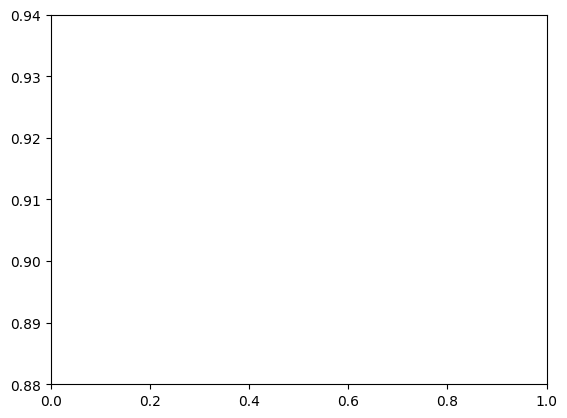

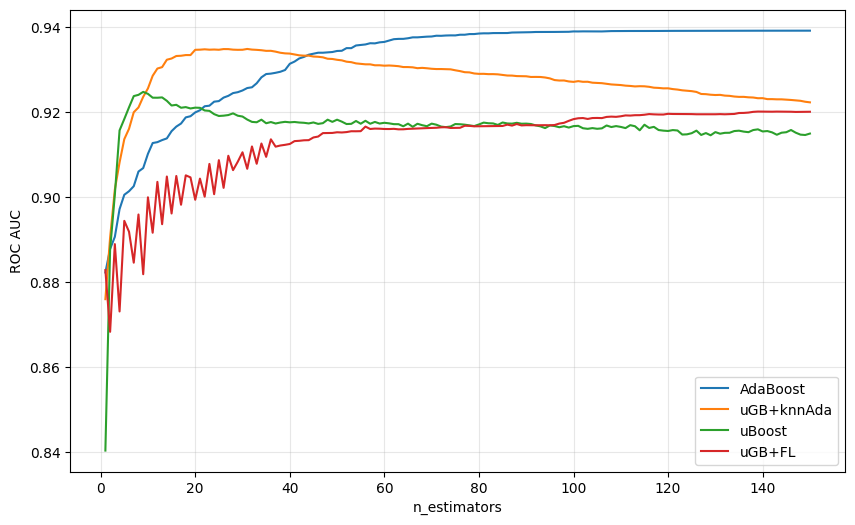

In [8]:
# Custom RocAuc metric class
class RocAuc:
    """Simple ROC AUC metric class"""

    def __init__(self):
        pass

    def __str__(self):
        return "ROC AUC"


report = classifiers.test_on(testX, testY)

plt.ylim(0.88, 0.94)
report.learning_curve(RocAuc(), steps=1)

## SDE (squared deviation of efficiency) learning curve
SDE vs the number of built trees. SDE is a metric of nonuniformity &mdash; less is better. 

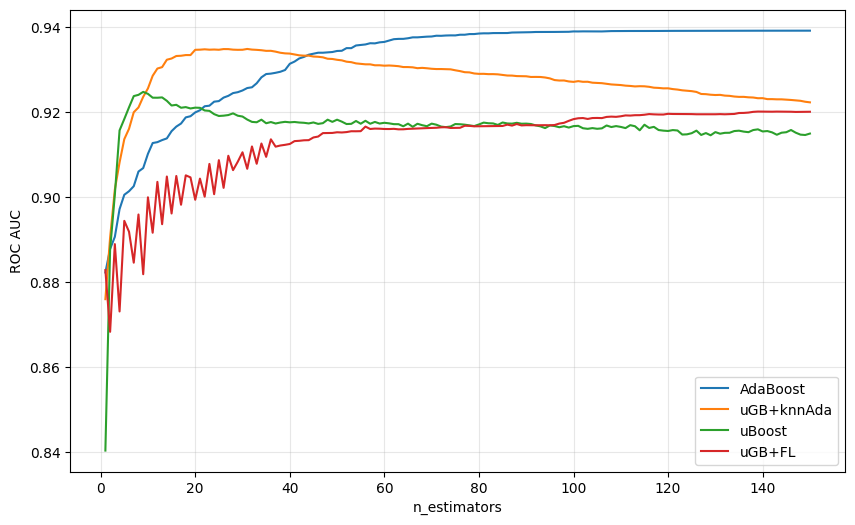

In [9]:
from hep_ml.metrics import BinBasedSDE, KnnBasedCvM

report.learning_curve(BinBasedSDE(uniform_features, uniform_label=1))

## CvM learning curve
CvM is a metric of non-uniformity based on Cramer-von Mises distance. We are using knn (based on neighbours) version here.

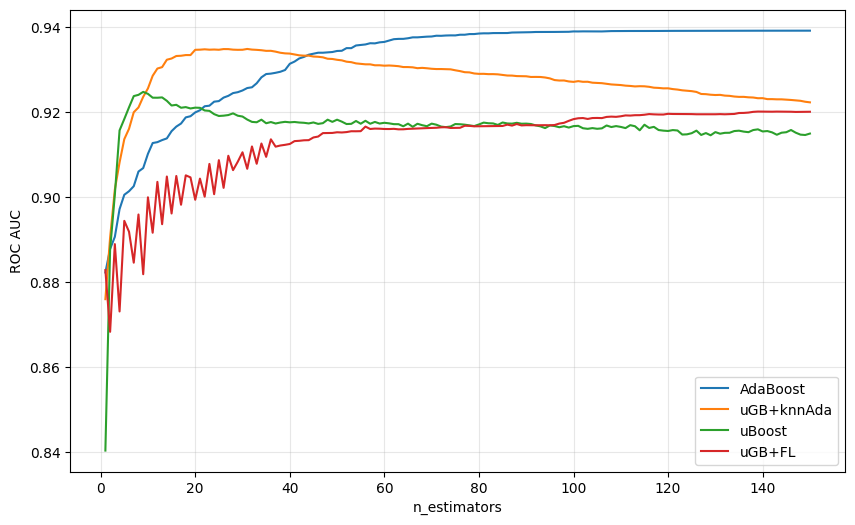

In [10]:
report.learning_curve(KnnBasedCvM(uniform_features, uniform_label=1))

# ROC curves after training

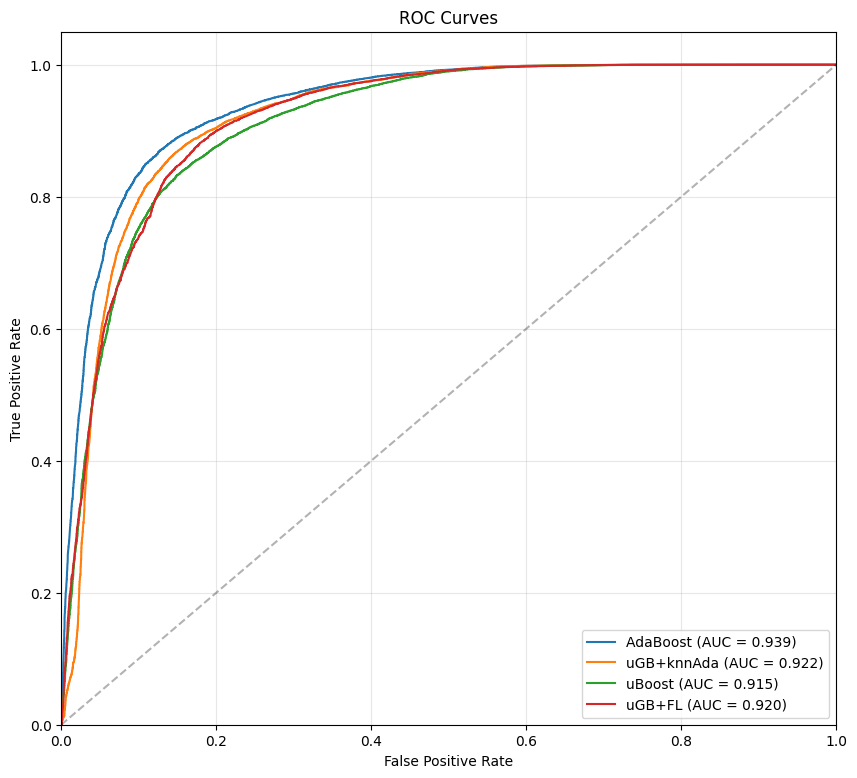

In [11]:
report.roc().plot(new_plot=True, figsize=[10, 9])

## Signal efficiency 
global cut corresponds to an average signal efficiency=0.5. In ideal case the picture shall be white.

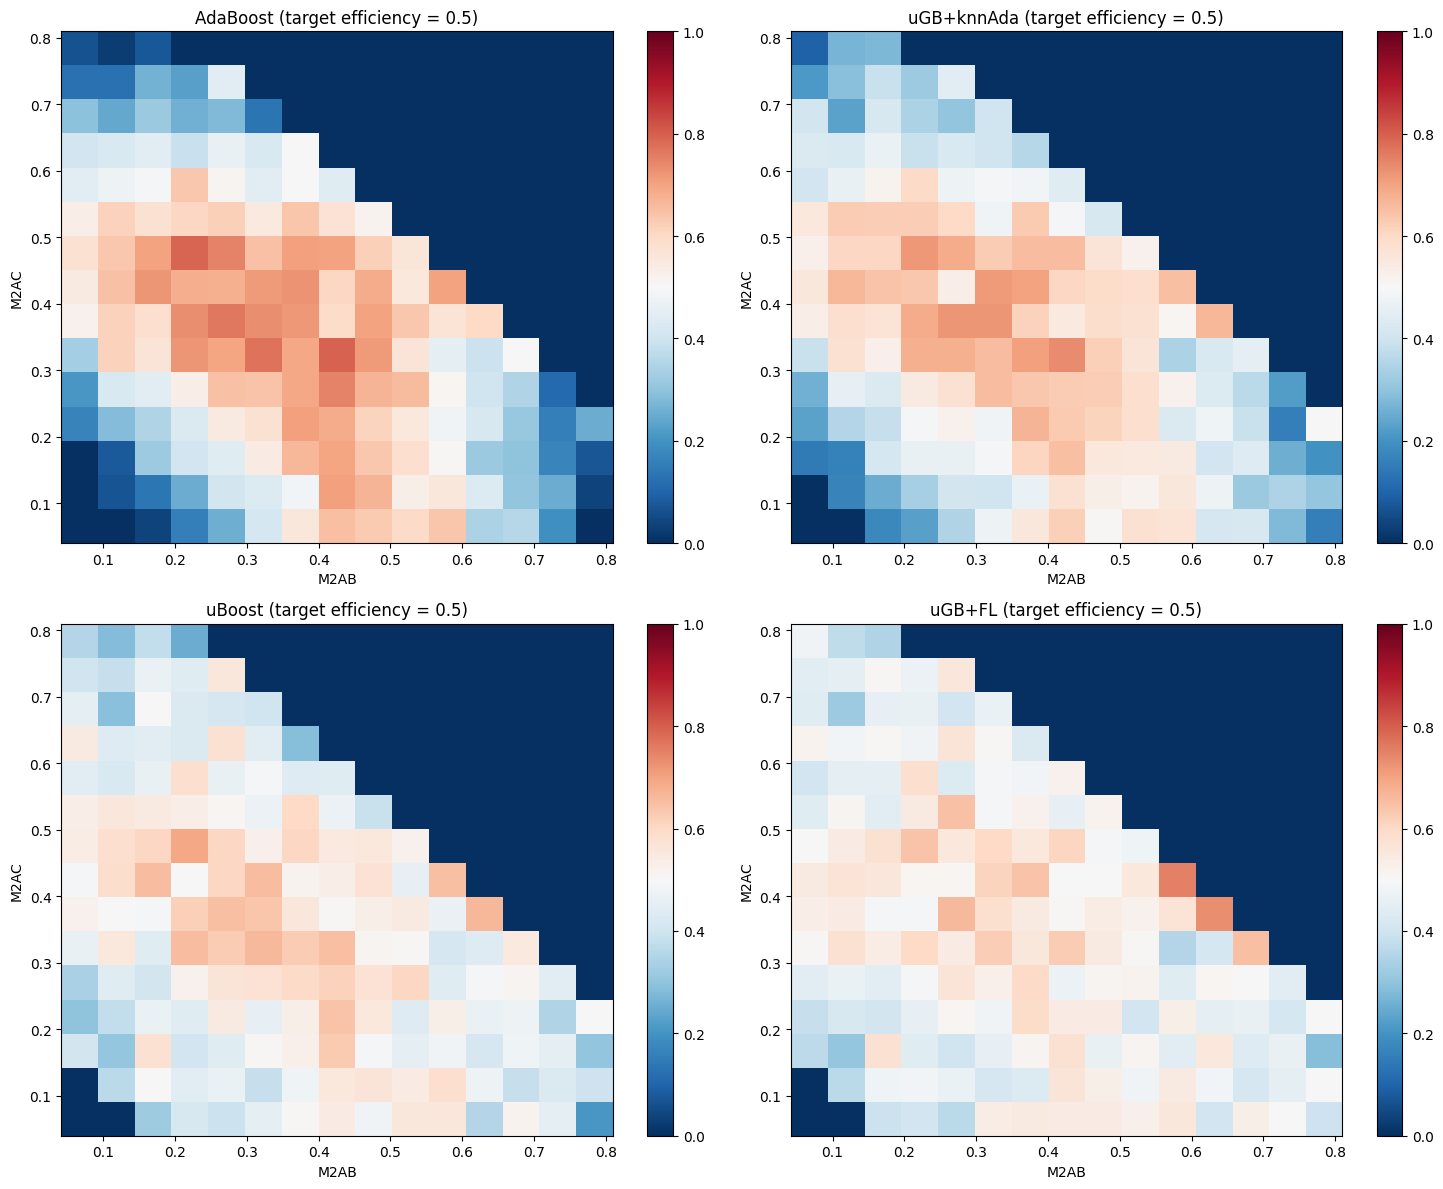

In [12]:
report.efficiencies_2d(uniform_features, efficiency=0.5, signal_label=1, n_bins=15, labels_dict={1: "signal"})

the same for global efficiency = 0.7

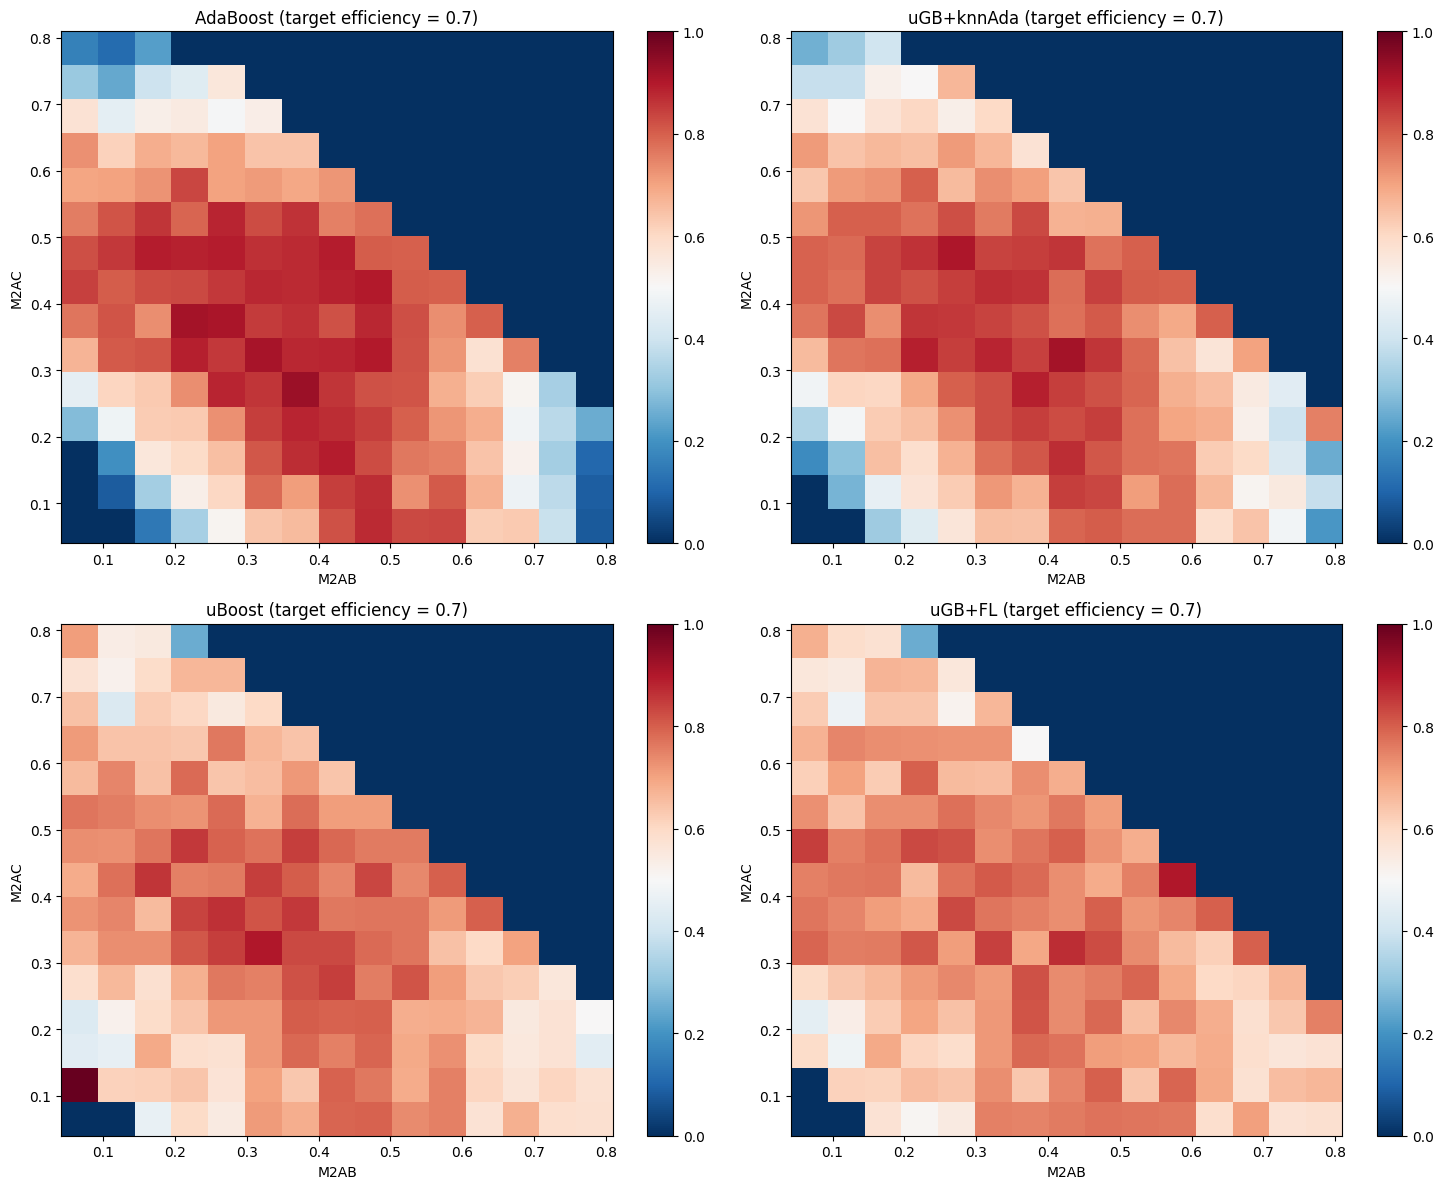

In [13]:
report.efficiencies_2d(uniform_features, efficiency=0.7, signal_label=1, n_bins=15, labels_dict={1: "signal"})